# Instrument Pricing Analytics - Volatility Surfaces

In one of my <a href="https://developers.refinitiv.com/article/discover-our-refinitiv-data-platform-library-part-2" target="_blank">earlier articles</a> on our new Refinitiv Data Platform Library, I briefly covered our Instrument Pricing Analytics (IPA) data content.

As it was meant to be an overview of the RDP Library, I only covered a fraction of the currently available IPA content. I also only highlighted a subset of the types of output that Samuel Schwam  (Director, Enterprise Pricing Analytics), demoed during the <a href="https://developers.refinitiv.com/pages/london-developer-day-agenda" target="_blank">London Developer Day event</a>. 

In this article I would like to cover one of these content types - the Volatility Surface offering - in more detail.

Volatility Surfaces, like other pricing data (ZC Curves, Inflation Curves), are used to model risk factors and can be used to power risk management or valuation systems. The Volatility Surface can also be analysed across Tenors or Strikes (as per the examples below) to get a sense of how the risk is distributed along these axis.

I think the best way to highlight this content is via some code and some colourful graphs - so let me dive straight into the code....


#### Initialisation

First thing I need to do is import my libraries and then run my scripts to define my helper functions. 
As you will note I am importing the Refinitiv Data Platform library which will be my main interface to the Platform - as well as few of the most commonly used Python libraries.


In [ ]:
import pandas as pd
import requests
import numpy as np
import json
import refinitiv.dataplatform as rdp

%run -i ./credentials.ipynb
%run ./plotting_helper.ipynb

As the names would suggest, the `credentials` file contains my login credentials and the `plotting_helper` contains the full plotting code. I will only share some of the key plotting code snippets in this article - for the rest please refer to the actual file.

### Connect to the Refintiv Data Platform
I am using my helper functions to establish a connection the Platform by requesting a session and opening it.

In [2]:
APP_KEY = get_app_key()
RDP_LOGIN     = get_rdp_login()
RDP_PASSWORD  = get_rdp_password()

session = rdp.PlatformSession(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)
session.open()

<State.Open: 3>

## Endpoint Interface
In my previous article I mentioned how the Refinitiv Data Platform library consists of three layers as follows:
1. Function: Highest level - single function call to get data
2. Content: High level - Fuller response and Level 1 Streaming data too
3. Delivery: For Level 2 Streaming data and data sets not supported by above Layers

Whilst there are plans to offer some Content layer support for IPA data, at present it is limited to the Delivery layer. Each unique content set on the Platform has its own Endpoint and we can use the Delivery Layers Endpoint interface to access that content.

Using the Endpoint interface to request IPA content is fairly straighforward
1. Identify the required IPA Endpoint (URL)
2. Use the Endpoint Interface to send a request to the Endpoint
3. Decode the response and extract the IPA data

### Identifying the Surfaces Endpoint
To ascertain the Endpoint, we can use the Refinitiv Data Platform's <a href="http://api.refinitiv.com/" target="_blank">API Playground</a> - an interactive documentation site you can access once you have a valid Refinitiv Data Platform account.

So, firstly I can search for *'surface'* to narrow down the list of Endpoints and then select the relevant Endpoint from the list. At present there is only one Endpoint for surfaces so that keeps it simple:

I copy the Endpoint URL - ***/data/quantitative-analytics-curves-and-surfaces/v1/surfaces*** - to use with the Endpoint interface as follows:

In [3]:
vs_endpoint = rdp.Endpoint(session, "https://api.edp.thomsonreuters.com/data/quantitative-analytics-curves-and-surfaces/v1/surfaces")

#### Build our JSON Request

Using the reference documentation or by referring to the example queries shown on the above API playground page, I can build up my Request.  

Currently there are two Underlying Types of Volatility Surface supported:
* Eti : exchange-traded instruments like equities, equity indices, and futures.
* Fx : Fx instruments.

For example the JSON request below, will allow me to generate an *ETI* Volatility Surface:
* for Renault, Peugeot, BMW and VW
* from the Option Settle prices using an SSVI model
* express the axes in Dates and Moneyness
* and return the data in a matrix format

The request is highly configurable and the various parameters & options are listed on the API playground. For example, for ETI, the options are :
* Volatility Model : SVI or SSVI (Surface SVI)
* Axes :  Tenor / Date and Moneyness / Strike
* Input : Settle or Implied
* Data format : Matrix or List

Another parameter worth mentioning is ***calculationDate*** which defaults to today - however, you can select upto 2 years in the past. 

Note from the request below, how I can obtain data for multiple entities in a single request.


In [4]:
eti_request_body={
    "universe": [
        {
            "surfaceTag": "RENAULT",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "RENA.PA"
            },
            "surfaceParameters": {
                "inputVolatilityType": "settle",
                "volatilityModel": "SSVI",
                "xAxis": "Date",
                "yAxis": "Moneyness"
            },
            "surfaceLayout": {
                "format": "Matrix",
            }
        },
        {
            "surfaceTag": "PEUGEOT",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "PEUP.PA"
            },
            "surfaceParameters": {
                "inputVolatilityType": "settle",
                "volatilityModel": "SSVI",
                "xAxis": "Date",
                "yAxis": "Moneyness"
            },
            "surfaceLayout": {
                "format": "Matrix"
            }
        },
        {
            "surfaceTag": "BMW",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "BMWG.DE"
            },
            "surfaceParameters": {
                "inputVolatilityType": "settle",
                "volatilityModel": "SSVI",
                "xAxis": "Date",
                "yAxis": "Moneyness"
            },
            "surfaceLayout": {
                "format": "Matrix"
            }
        },
        {
            "surfaceTag": "VW",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "VOWG.DE"
            },
            "surfaceParameters": {
                "inputVolatilityType": "settle",
                "volatilityModel": "SSVI",
                "xAxis": "Date",
                "yAxis": "Moneyness"
            },
            "surfaceLayout": {
                "format": "Matrix"
            }
        }],
    
    "outputs":["ForwardCurve"]
}

I then send the request to the Platform using the instance of Endpoint interface I created:

In [5]:
eti_response = vs_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = eti_request_body
)
print(json.dumps(eti_response.data.raw, indent=2))

{
  "data": [
    {
      "surfaceTag": "RENAULT",
      "surface": [
        [
          null,
          "0.5",
          "0.6",
          "0.7",
          "0.75",
          "0.8",
          "0.85",
          "0.9",
          "0.95",
          "0.975",
          "1",
          "1.025",
          "1.05",
          "1.1",
          "1.15",
          "1.2",
          "1.25",
          "1.3",
          "1.4",
          "1.5"
        ],
        [
          "2020-04-17",
          153.4806161401,
          141.76580448331,
          131.3946214293,
          126.649867218204,
          122.19106501963299,
          118.027935328804,
          114.183952949743,
          110.69807979094799,
          109.106307296821,
          107.626597580826,
          106.268851679783,
          105.04404136717001,
          103.04140338580801,
          101.71889284084601,
          101.170594489655,
          101.46115664859501,
          102.600969686302,
          107.136543538055,
          113.7451

Once I get the response back, I extract the payload and use the Matplotlib library to plot my surface. For example, below I extract and plot the Volatility Surface data for 'VW'.

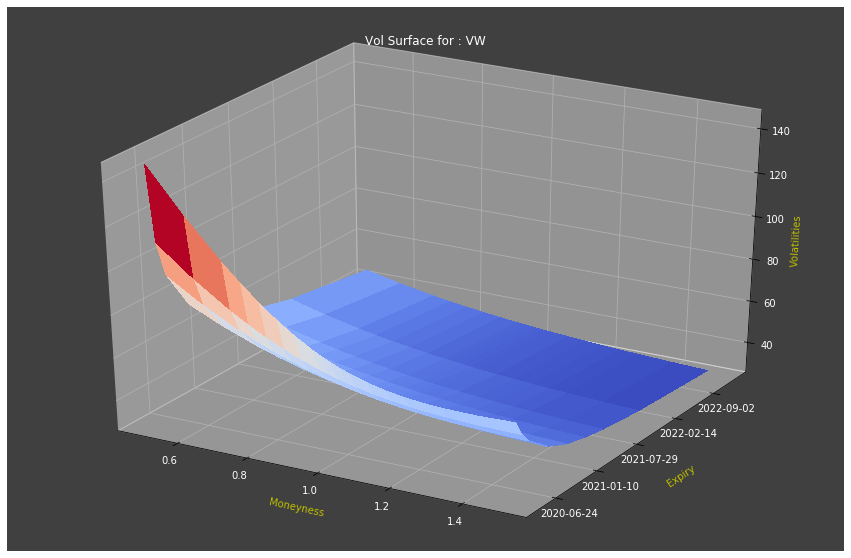

In [6]:
surfaces = eti_response.data.raw['data']
plot_surface(surfaces, 'VW')

Where the key bits of code for plot_surface are :

In [7]:
# The Full code is in the plotting_helper file
def plot_surface_snip(surfaces, surfaceTag):
    surfaces = pd.DataFrame(data=surfaces)
    surfaces.set_index('surfaceTag', inplace=True)
    surface = surfaces[surfaces.index == surfaceTag]['surface'][0]
    
    strike_axis = surface[0][1:]
    surface = surface[1:]
    time_axis = []
    surface_grid = []
    for line in surface:
        time_axis.append(line[0])
        surface_grid_line = line[1:]
        surface_grid.append(surface_grid_line)

    time_axis = convert_yyyymmdd_to_float(time_axis)
    
    x = np.array(strike_axis, dtype=float)
    y = np.array(time_axis, dtype=float)
    Z = np.array(surface_grid, dtype=float)
    
    X,Y = np.meshgrid(x,y)
    
    ax.w_yaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    
    surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)    
    plt.show()

At present the IPA Product team recognise that the returned data format is less than ideal for plotting and requires a bit of manipulation, so they are looking to improve this. I will endeavour to update this code as and when that happens.  
Note that I have used a formatter for the yAxis label in order to show the dates rather than the floating point date format required by `matplotlib` (see the *plotting_helper* notebook for the full code).

### Smile Curve
I can also use the same surfaces response data to plot a Smile Curve.

For example, to compare the volatility smiles of the 4 equities at the chosen expiry time (where the maturity value of 1 is the first expiry):

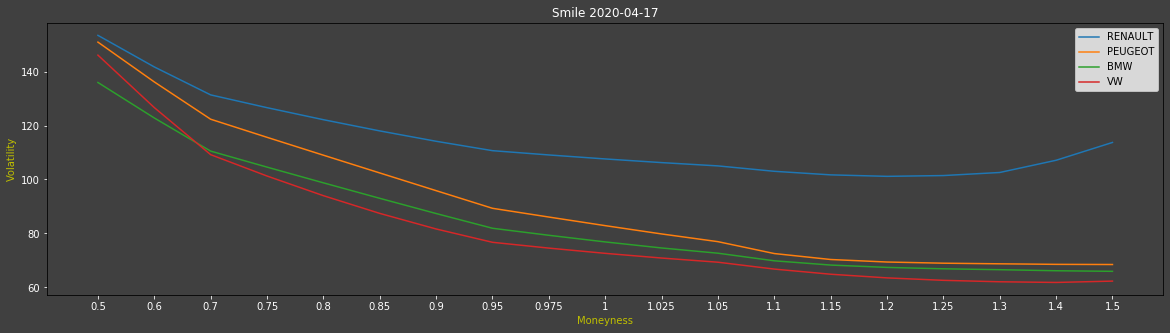

In [8]:
plot_smile(surfaces, 1)

Where the key bits of code for plot_smile are :

In [9]:
# The full code is in the plotting_helper file
def plot_smile_snip(surfaces, maturity):

    surfaces = pd.DataFrame(data=surfaces)

    for i in range(0,surfaces.shape[0]):
        label = surfaces.loc[i,['surfaceTag']]['surfaceTag']
        surface = surfaces.loc[i,['surface']]['surface']
        error = surfaces.loc[i,['error']]['error'] if 'error' in surfaces else 0.0

        x=[]
        y=[]
        if (type(error) is float):
            x = surface[0][1:]
            y = surface[maturity][1:]
            title = 'Smile ' + str(surface[maturity][0])
            ax.plot(x,y,label=label)
            
    plt.show()

### Volatility Terms
We can also use the same surfaces response data to plot the Term Structure (the full code for all the plots can be found in the plotting_helper file)

Let the user to choose the Moneyness index - **integer value** - to use for the chart:

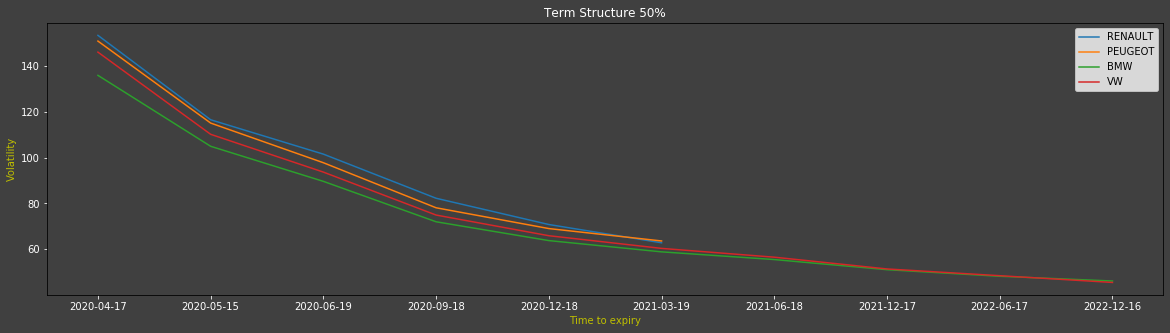

In [10]:
moneyness=1 #int(input("Moneyness:"))
plot_term_volatility(surfaces, moneyness)

### Forward Curve
Finally, observe that I can also use the same data to plot a Forward Curve e.g. for Renault:

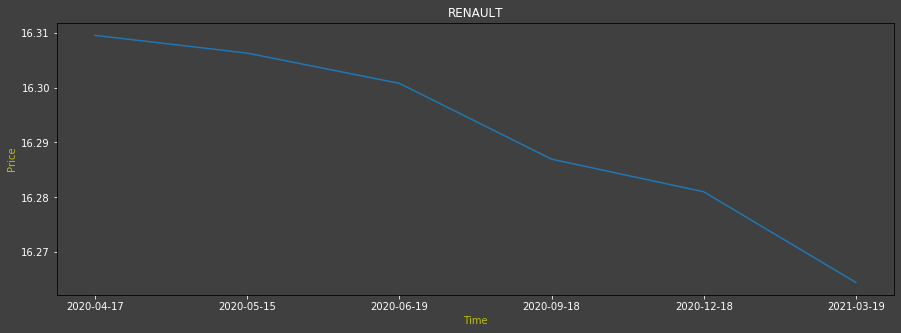

In [11]:
plot_forward_curve(surfaces, 'RENAULT')

### FX Volatility Surface
I can also use the same IPA Endpoint to request FX Volatility Surfaces 

For example the request below, will allow me to generate an FX volatility surface:

for EURUSD, GBPUSD and CFHUSD cross rates  
express the axes in Dates and Delta  
and return the data in a matrix format  

As I mentioned earlier,  the request is configurable and the parameters & options are listed on the API playground. 
For example, for the 4 parameters I used, the options are :

* Volatility Model : SVI (the default and only option)
* Axes : Delta/Strike and Tenor/Date
* Input : Implied (the default and only option)
* Data format : Matrix or List

With the previous ETI request, I explained that the ***calculationDate*** defaults to today's date and can be overridden - as I have done below: 


In [12]:
fx_request_body={
    "universe": [
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-GBPUSD",
              "underlyingDefinition": {
                "fxCrossCode": "GBPUSD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z",
                "returnAtm": "True"
              }
        },
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-EURUSD",
              "underlyingDefinition": {
                "fxCrossCode": "EURUSD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z",
                "returnAtm": "True"
              }
        },
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-CHFUSD",
              "underlyingDefinition": {
                "fxCrossCode": "CHFUSD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z",
                "returnAtm": "True"
              }
        }
    ]
}

fx_response = vs_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = fx_request_body
)

print(json.dumps(fx_response.data.raw, indent=2))

{
  "data": [
    {
      "surfaceTag": "FxVol-GBPUSD",
      "surface": [
        [
          null,
          -0.1,
          -0.15,
          -0.2,
          -0.25,
          -0.3,
          -0.35,
          -0.4,
          -0.45,
          0.0,
          0.45,
          0.4,
          0.35,
          0.3,
          0.25,
          0.2,
          0.15,
          0.1
        ],
        [
          "2018-08-21T00:00:00Z",
          8.474304079340165,
          8.28725273729482,
          8.150419367003044,
          8.042395602302943,
          7.953593335183968,
          7.878996963438836,
          7.81580173425316,
          7.762474980925678,
          7.718366253495301,
          7.683547886830561,
          7.658891314968792,
          7.6463251372674845,
          7.649400323506564,
          7.674568043116656,
          7.734123792587141,
          7.853998599009499,
          8.099355202033308
        ],
        [
          "2018-08-27T00:00:00Z",
          7.216782574143219,

Once again, I extract the payload and plot my surface - below I extract and plot the Volatility Surface for 'Swiss Franc / US Dollar'.

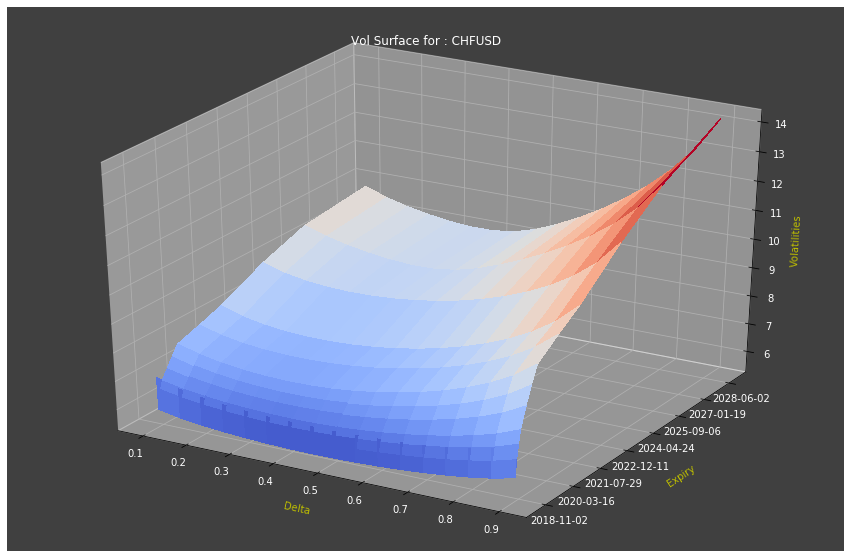

In [13]:
fx_surfaces = fx_response.data.raw['data']
plot_surface(fx_surfaces, 'FxVol-CHFUSD', True)

### Plot other Curves with same data

As with the ETI Surface Curve data, I can also use the FX data to plot other curves i.e. Smile curve and also a Volatility Term curve.  
I have used the 3rd strike to plot the 3rd maturity term below:  


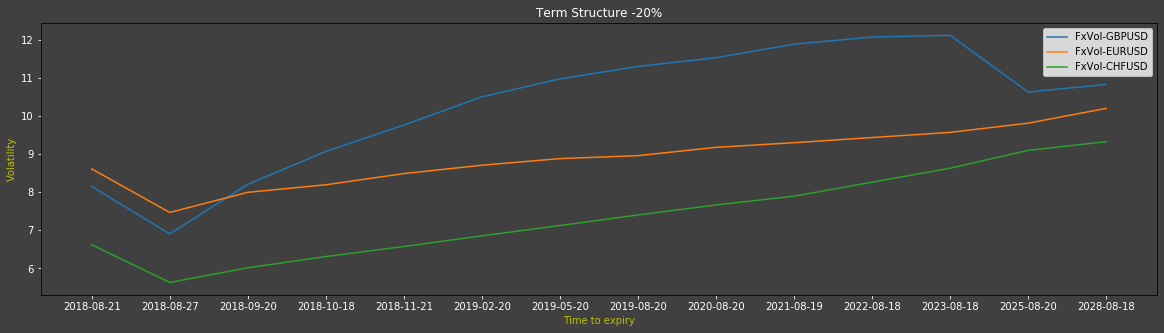

In [14]:
plot_term_volatility(fx_surfaces, 3)

Currently, the date format for ETI and FX data differs - the ETI returns a Date only and the FX returns Date & Time. As a consequence, if you refer to the `plot_term_volatility` code, you can see that I am stripping the time to make the x axis label look neater.

Also, since I am specifying *'Delta'* rather than *'Strike'* for `yAxis` value in my JSON request above - I can also plot a Smile curve with the same data. 

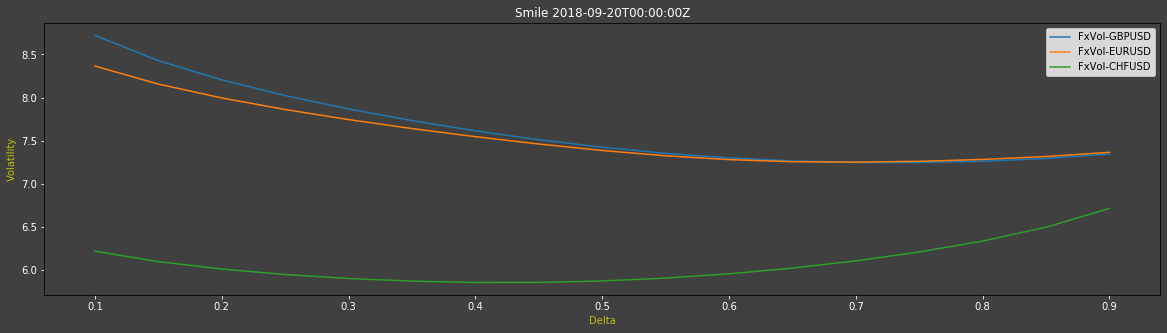

In [15]:
plot_smile(fx_surfaces, 3, True)

### Closing Summary

I hope I have demonstrated that the Instrument Pricing Analytics is indeed a powerful offering and that the Surface Volatility API/Endpoint is a very flexible one - allowing the generation of Volatility Surfaces for both Exchange traded and FX instruments as well as other curves such as Smile, Volatility Term, and Forward curves.

If you found this useful, please keep an eye out for my next article on the **Zero Coupon Curves Endpoint** where I hope to cover Bi-curves, Currency Basis Swap Adjusted curves and Collateral Currency Adjustment. 

#### Acknowledgements
Although I modified the code for the plots in this article (to improve their look and format), the starting point was Samuel Schwalm's (Director, Enterprise Pricing Analytics) Surfaces and Curves notebook - for which I thank him.


### References
<a href="https://developers.refinitiv.com/article/discover-our-refinitiv-data-platform-library-part-1" target="_blank">Discover our new Refinitiv Data Platform Library</a> - Part 1 of RDP intro article

<a href="http://api.refinitiv.com/" target="_blank">API Playground</a> - Interactive Documentation for Refinitiv Data Platform APIs.

RDP EAP library on <a href="http://pypi.org/project/refinitiv-dataplatform/" target="_blank">PyPi</a> - install by executing 'pip install refinitiv-dataplatform' - in your Python environment

<a href="https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-apis" target="_blank"> Refinitiv Data Platform APIs</a> - our existing REST-based interface to the cloud Platform.

<a href="https://community.developers.refinitiv.com/spaces/321/index.html" target="_blank">Q&A Forum</a> for the Refinitiv Data Platform Library 

**Disclaimer**  
As this article is based on Beta versions, the method signatures, data formats etc are subject to change.
